#**Итоговая аттестационная работа.**

**Повышение помехозащищённости ультразвуковых расходомеров с помощью машинного обучения.**

##1)Проработка бизнес-задачи проекта (проблематика проекта).

Принцип действия ультразвуковых расходомеров основан на измерении разницы во времени прохождения сигнала. При этом два ультразвуковых датчика, расположенные по диагонали трубопровода друг напротив друга, попеременно излучают и принимают сигнал. Таким образом, акустический сигнал, поочередно генерируемый обоими сенсорами, ускоряется, когда направлен по потоку, и замедляется, когда направлен против потока. Разница во времени, возникающая вследствие прохождения сигнала по измерительному каналу в обоих направлениях, прямо пропорциональна средней скорости потока, на основании которой можно затем рассчитать объёмный расход.

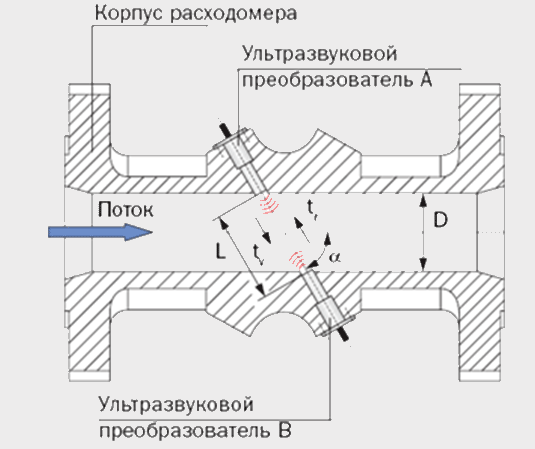

Разница во времени прохождения сигнала по измерительному каналу в обоих направлениях очень мала - на низких расходах измеряемой среды составляет десятки пикосекунд и измеряется время-цифровым преобразователем . По этому важно всегда измерять время относительно одной и той же полуволны принимаемого сигнала. На этот процесс большое влияние оказывают помехи, как внутренние — внутри трубопровода, так и внешние — различные электромагнитные и акустические помехи.

Даже при правильном монтаже расходомера с соблюдением длины прямого участка трубопровода и удалённости от редукционных устройств, особенно, при больших расходах измеряемого вещества в трубопроводах возникают ультразвуковые помехи, которые, накладываясь на полезный сигнал приёмопередатчиков искажают показания и снижают динамический диапазон расходомера.

Так-как классические методы фильтрации аналоговых и цифровых сигналов не решают всех поставленных задач, необходимо разработать алгоритм обработки сигналов инструментами и методами искусственного интеллекта. Это позволит улучшить метрологические качества расходомера, что будет являться большим конкурентным преимуществом. Также ультразвуковые расходомеры с повышенной помехозащищённостью возможно устанавливать вместо устаревающих механических (ротационных) счётчиков, не соответствующих современным метрологическим нормам, и имеющих маленький динамический диапазон измерений, но обладающими низкими требованиями к условиям монтажа.

In [ ]:
# Подключение гугл диска
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from matplotlib import pyplot as plt 
import numpy as np 
import glob
import pandas as pd
from sklearn.svm import SVC
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.neighbors import KNeighborsClassifier

##2)Сбор данных.

Данные для  обучения и проверки искусственного интеллекта соберём сохраненяя результаты измерения аналого-цифрового преобразователя(АЦП) в csv файл. При этом каждый отдельный файл является набором чисел, равным продожительности измерения АЦП. Огибающая построенная по этим числам представляет из себя осциллограмму сигнала. Датасет сигналов не пригодных для измерения был собран методом моделирования условий возникновения помех.

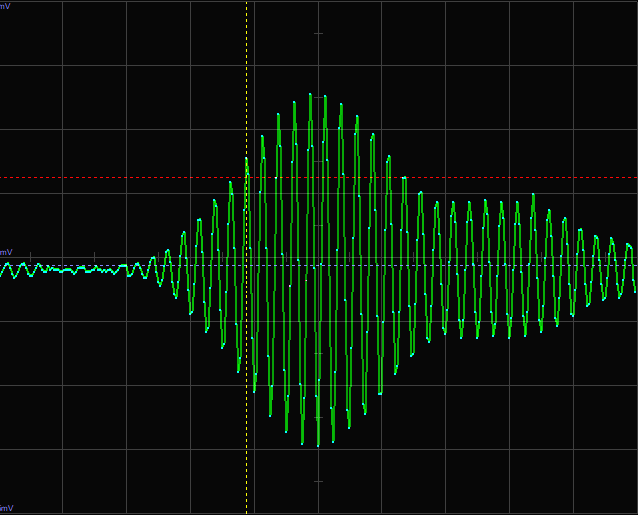



In [ ]:
# Осциллограммы сигналов пригодных для измерения.
# Так как каждая осциллограмма сохранена в отдельном csv файле, переберём все 
# файлы, возьмём из них нужный столбец и добавим в общий датафрейм.
signals_good = glob.glob('/content/drive/MyDrive/Итоговая аттестация/осц х/*.csv')
number = -1
for i in signals_good:
# Загрузить датасет.
  number +=1
  if number == 0: # Создаём датафрейм.
    signals_good_1 = pd.read_csv(i, sep=' ', header=None)
    signals_good_1 = signals_good_1.dropna(axis=1) # Удалить пустую колонку.
    # Преобразовать из столбца в строку.
    col_g = []
    for j in range(len(signals_good_1[1])):
      col_g.append(signals_good_1.iloc[j,0])
    signals_good_1 = pd.DataFrame([col_g],index=['col_g_' + str(number)]) # Добавить название строки.
  else: # Добавляем информацию в существующий датафрейм
    signals_good_2 = pd.read_csv(i, sep=' ', header=None)
    signals_good_2 = signals_good_2.dropna(axis=1) # Удалить пустую колонку.
    # Преобразовать из столбца в строку.
    col_g = []
    for k in range(332):
      col_g.append(signals_good_2.iloc[k,0])
    signals_good_2 = pd.DataFrame([col_g],index=['col_g_' + str(number)]) # Добавить название строки.
    signals_good_1 = pd.concat([signals_good_1,signals_good_2]) # Добавить строку.
signals_good_1.head(10000)

,0,1,2,3,4,5,6,7,8,9,...,322,323,324,325,326,327,328,329,330,331
col_g_0,122,125,124,124,122,120,120,120,122,125,...,132,124,115,110,110,120,129,134,133,132
col_g_1,120,122,124,124,123,121,120,121,123,124,...,129,118,110,110,116,126,133,134,128,119
col_g_2,121,122,124,124,123,120,120,120,121,124,...,133,127,118,110,112,117,126,133,134,132
col_g_3,120,123,123,124,124,122,119,120,121,123,...,133,129,120,112,109,115,124,132,135,132
col_g_4,121,124,125,125,122,120,118,119,120,125,...,132,124,114,109,112,119,128,133,132,125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
col_g_144,120,122,123,124,124,121,121,120,121,124,...,133,125,115,110,113,120,128,134,133,130
col_g_145,120,122,124,126,124,122,120,120,122,123,...,130,121,114,111,114,123,131,133,130,122
col_g_146,119,122,123,124,124,122,120,120,120,122,...,132,121,112,108,113,123,132,139,131,122
col_g_147,120,122,124,126,124,121,120,119,121,123,...,128,117,109,109,117,127,134,134,128,118


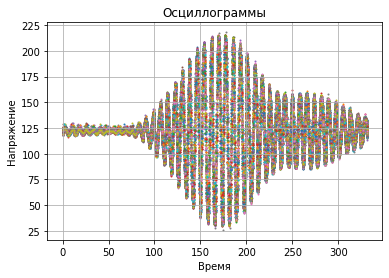

In [ ]:
# Визуализация осциллограмм сигналов, пригодных для измерения, наложенных друг на друга.
for i in range(149): # Количество осциллограмм.
  plt.scatter(signals_good_1.columns, signals_good_1.iloc[[i]], s=1) 
plt.grid(True) # Координатная сетка.
plt.title(u'Осциллограммы')
plt.xlabel(u'Время')
plt.ylabel(u'Напряжение')
plt.show()

In [ ]:
# Осциллограммы сигналов не пригодных для измерения.
# Так как каждая осциллограмма сохранена в отдельном csv файле, переберём все 
# файлы, возьмём из них нужный столбец и добавим в общий датафрейм.
signals_bad = glob.glob('/content/drive/MyDrive/Итоговая аттестация/осц п/*.csv')
number = -1
for i in signals_bad:
# Загрузить датасет.
  number +=1
  if number == 0: # Создаём датафрейм.
    signals_bad_1 = pd.read_csv(i, sep=' ', header=None)
    signals_bad_1 = signals_bad_1.dropna(axis=1) # Удалить пустую колонку.
    # Преобразовать из столбца в строку.
    col_g = []
    for j in range(len(signals_bad_1[1])):
      col_g.append(signals_bad_1.iloc[j,0])
    signals_bad_1 = pd.DataFrame([col_g],index=['col_b_' + str(number)]) # Добавить название строки.
  else: # Добавляем информацию в существующий датафрейм
    signals_bad_2 = pd.read_csv(i, sep=' ', header=None)
    signals_bad_2 = signals_bad_2.dropna(axis=1) # Удалить пустую колонку.
    # Преобразовать из столбца в строку.
    col_g = []
    for k in range(332):
      col_g.append(signals_bad_2.iloc[k,0])
    signals_bad_2 = pd.DataFrame([col_g],index=['col_b_' + str(number)]) # Добавить название строки.
    signals_bad_1 = pd.concat([signals_bad_1,signals_bad_2]) # Добавить строку.
signals_bad_1.head(10000)

,0,1,2,3,4,5,6,7,8,9,...,322,323,324,325,326,327,328,329,330,331
col_b_0,151,165,153,122,92,81,94,126,154,163,...,124,122,119,119,121,122,123,124,124,122
col_b_1,120,121,122,122,123,122,121,121,123,126,...,196,167,113,65,48,75,127,180,197,171
col_b_2,125,126,125,125,125,125,124,124,124,127,...,158,149,124,100,89,100,124,145,150,138
col_b_3,128,129,129,128,127,124,122,119,118,117,...,124,123,124,125,124,123,122,122,123,125
col_b_4,110,118,128,137,135,127,116,108,109,119,...,22,0,11,122,231,255,224,110,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
col_b_70,99,101,114,133,145,145,129,112,102,105,...,129,118,110,110,118,128,135,133,124,116
col_b_71,117,119,123,126,126,124,120,117,118,122,...,125,115,111,110,119,128,134,133,125,116
col_b_72,117,143,157,151,127,100,86,96,120,148,...,164,99,50,46,90,151,193,191,148,92
col_b_73,125,98,86,95,121,148,159,149,123,95,...,125,121,119,117,119,123,126,127,126,122


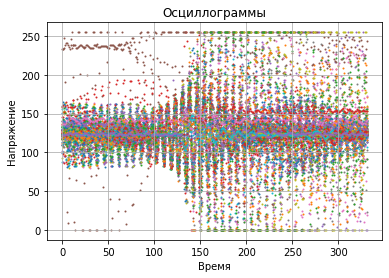

In [ ]:
# Визуализация осциллограмм сигналов, не пригодных для измерения, наложенных друг на друга.
for i in range(75): # Количество осциллограмм.
  plt.scatter(signals_bad_1.columns, signals_bad_1.iloc[[i]], s=1) 
plt.grid(True) # Координатная сетка.
plt.title(u'Осциллограммы')
plt.xlabel(u'Время')
plt.ylabel(u'Напряжение')
plt.show()

##3)Подготовка данных.

Датасет осциллограмм пригодных для обработки получился размером в 149 строк.
Датасет осциллограмм не пригодных для обработки получился размером в 75 строк.
Для применения алгоритмов обучения с учителем  разделим их на обучающую (75%) и тестовую (25%) части. Далее объединим их в общий обучающий и тестовый датасеты. 
Также сформируем целевые функции (“правильные ответы“) обучающего и тестового датасетов.

In [ ]:
# Разделим датасет осциллограмм пригодных сигналов 
# на тренировочную 112(0-111) и проверочную части 37(112-148). 
signals_good_1_tren = signals_good_1.loc['col_g_0':'col_g_111', :]
signals_good_1_test = signals_good_1.loc['col_g_112':'col_g_148', :]

In [ ]:
# Разделим датасет осциллограмм не пригодных сигналов 
# на тренировочную 57(0-56) и проверочную части 18(57-74).
signals_bad_1_tren = signals_bad_1.loc['col_b_0':'col_b_56', :]
signals_bad_1_test = signals_bad_1.loc['col_b_57':'col_b_74', :]

In [ ]:
# Сформируем тренировочный датасет.
signals_tren = pd.concat([signals_good_1_tren,signals_bad_1_tren]) # Объединить строки.
# Сформируем тестовый датасет.
signals_test = pd.concat([signals_good_1_test,signals_bad_1_test]) # Объединить строки.

In [ ]:
# Сформируем целевую функцию тренировочного датасета.
tra = []
for g in range(169):
  if g <= 111:  # Первые 112 - осциллограммы хороших сигналов.
    tra.append(1)
  else:        # Оставшиеся 57 - осциллограммы плохих сигналов.
    tra.append(0)
y_train = np.array(tra)
print(y_train)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
# Сформируем целевую функцию тестового датасета.
tes = []
for g in range(55):
  if g <= 36:  # Первые 37 - осциллограммы хороших сигналов.
    tes.append(1)
  else:        # Оставшиеся 18 - осциллограммы плохих сигналов.
    tes.append(0)
y_test = np.array(tes)
print(y_test)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


#4)Моделирование

Произведём обработку собранных данных несколькими методами машинного обучения, оценим их работу на тестовых данных и выберем метод показавший лучшие результаты "предсказания".


## Классификация методом опорных векторов (SVM)

In [ ]:
# Создать модель как объект класса SVC
clf = svm.SVC() 
# Обучаем модель с помощью функции fit.
clf.fit(signals_tren, y_train) 

SVC()

In [ ]:
# Выведем получившиеся опорные вектора.
clf.support_vectors_ 

array([[151., 165., 153., ..., 124., 124., 122.],
       [ 93., 124., 154., ..., 128., 148., 154.],
       [156., 142., 118., ..., 127., 128., 130.],
       ...,
       [120., 123., 124., ..., 135., 131., 123.],
       [122., 124., 124., ..., 133., 125., 115.],
       [122., 123., 124., ..., 133., 124., 118.]])

In [ ]:
# Проверка работы модели на тестовых данных (25%).
pred = clf.predict(signals_test) 
pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

**Метрики оценки работы модели на тестовых данных.**

In [ ]:
print('Доля верных ответов -', accuracy_score(y_test, pred)) # Доля верных ответов.
print('Количество правильных ответов -', accuracy_score(y_test, pred, normalize=False), 'из 55') # Количество правильных ответов.
# Точность - способность не помечать как положительный образец, образец который является отрицательным.
# tp / (tp + fp), где tp-количество истинных срабатываний и fp-количество ложных срабатываний.
print('Точность -', precision_score(y_test, pred, average='micro')) 
# Cпособность классификатора находить все положительные образцы.
# tp / (tp + fn), где tp-количество истинных положительных результатов и fn-количество ложных отрицательных результатов.
print('Полнота -', recall_score(y_test, pred, average='macro'))

Доля верных ответов - 0.9818181818181818
Количество правильных ответов - 54 из 55
Точность - 0.9818181818181818
Полнота - 0.9722222222222222


## Классификация методом k-ближайших соседей.

In [ ]:
# Создать модель как объект класса 
knn = KNeighborsClassifier() # По умолчанию количество ближайших соседей = 5

In [ ]:
# Обучаем модель с помощью функции fit.
knn = knn.fit(signals_tren, y_train)  

In [ ]:
# Проверка работы модели на тестовых данных (25%).
prediction = knn.predict(signals_test) # Предсказание
print(prediction)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]


**Метрики оценки работы модели на тестовых данных.**

In [ ]:
print('Доля верных ответов -', accuracy_score(y_test, prediction)) # Доля верных ответов.
print('Количество правильных ответов -', accuracy_score(y_test, prediction, normalize=False), 'из 55') # Количество правильных ответов.
# Точность - способность не помечать как положительный образец, образец который является отрицательным.
# tp / (tp + fp), где tp-количество истинных срабатываний и fp-количество ложных срабатываний.
print('Точность -', precision_score(y_test, prediction, average='micro')) 
# Cпособность классификатора находить все положительные образцы.
# tp / (tp + fn), где tp-количество истинных положительных результатов и fn-количество ложных отрицательных результатов.
print('Полнота -', recall_score(y_test, prediction, average='macro'))

Доля верных ответов - 0.9818181818181818
Количество правильных ответов - 54 из 55
Точность - 0.9818181818181818
Полнота - 0.9722222222222222


##Последовательная нейросеть

In [ ]:
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential # Последовательная модель.
from keras.layers import Dense # Слои.
import tensorflow as tf
import tensorflow.keras as keras

In [ ]:
# Масштабирование тренировочной выборки.
x_values = signals_tren
st = StandardScaler()
x_values = st.fit_transform(x_values)
signals_tren_df = pd.DataFrame(x_values) 

In [ ]:
# Масштабирование тестовой выборки.
y_values = signals_test
st = StandardScaler()
y_values = st.fit_transform(y_values)
signals_test_df = pd.DataFrame(y_values) 

In [ ]:
signals_tren_df.head(10000)

,0,1,2,3,4,5,6,7,8,9,...,322,323,324,325,326,327,328,329,330,331
0,-0.078843,-0.060629,-0.247367,-0.220303,-0.174255,-0.062007,0.050400,-0.020213,-0.110295,-0.117571,...,-0.054324,-0.022373,0.001642,-0.052582,-0.189528,-0.121395,-0.107581,-0.055165,0.013614,0.346913
1,-0.248581,-0.278634,-0.247367,-0.220303,-0.090355,0.007854,0.050400,0.059229,-0.023999,-0.186323,...,-0.194132,-0.292441,-0.229667,-0.052582,0.081150,0.168922,0.092212,-0.055165,-0.211956,-0.284021
2,-0.163712,-0.278634,-0.247367,-0.220303,-0.090355,-0.062007,0.050400,-0.020213,-0.196591,-0.186323,...,-0.007721,0.112662,0.140428,-0.052582,-0.099302,-0.266554,-0.257426,-0.103976,0.058728,0.346913
3,-0.248581,-0.205965,-0.316012,-0.220303,-0.006454,0.077716,-0.016668,-0.020213,-0.196591,-0.255076,...,-0.007721,0.202685,0.232952,0.037635,-0.234641,-0.363327,-0.357322,-0.152787,0.103842,0.346913
4,-0.163712,-0.133297,-0.178722,-0.140919,-0.174255,-0.062007,-0.083735,-0.099656,-0.282886,-0.117571,...,-0.054324,-0.022373,-0.044620,-0.097690,-0.099302,-0.169781,-0.157529,-0.103976,-0.031500,0.007179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,0.854718,0.811392,0.301796,-0.379072,-1.097162,-0.900343,-0.352006,0.694771,1.011547,0.707459,...,-0.520350,1.372983,2.453525,1.932174,0.351828,-1.621370,-2.854738,-2.251666,-0.437526,1.511714
165,1.958018,1.465408,1.674704,2.637531,3.433473,2.802307,2.330703,1.965853,1.615616,1.463736,...,0.924332,1.237949,1.759596,2.112606,1.795445,1.572124,1.141127,0.872246,0.915894,1.366114
166,-1.776227,-2.749359,-2.238083,-0.696609,1.671559,2.453000,1.928297,0.377000,-1.836206,-2.386403,...,-0.147529,-0.247430,-0.322191,-0.233014,-0.009076,0.314081,0.391902,0.237701,-0.121728,-0.526688
167,0.090895,-0.133297,-0.247367,-0.140919,-0.090355,0.147577,0.184536,0.218115,-0.196591,-0.186323,...,-0.427145,-0.067384,0.325476,0.488715,0.351828,-0.024623,-0.307374,-0.592088,-0.392412,-0.041354


In [ ]:
# Создать последовательную модель.
model = Sequential()
# Добавление слоёв.
model.add(Dense(100, input_dim=332, activation='relu')) # 6-количество узлов, 332-количество исходных данных.
model.add(Dense(50, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # Сборка модели.

In [ ]:
model.summary() # Не обученная модель.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               33300     
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 2)                 102       
                                                                 
Total params: 38,452
Trainable params: 38,452
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from tensorflow.keras.utils import to_categorical
y_train_cat = y_train 
y_train_cat = to_categorical(y_train_cat)

In [ ]:
y_test_cat = y_test 
y_test_cat = to_categorical(y_test_cat)

In [ ]:
# Обучение нейросети.
model.fit(signals_tren_df, y_train_cat, epochs=30) # epochs-количество эпох.

Epoch 1/30
6/6 [==============================] - 1s 4ms/step - loss: 0.5312 - accuracy: 0.7160
Epoch 2/30
6/6 [==============================] - 0s 4ms/step - loss: 0.1915 - accuracy: 0.9645
Epoch 3/30
6/6 [==============================] - 0s 4ms/step - loss: 0.1101 - accuracy: 0.9763
Epoch 4/30
6/6 [==============================] - 0s 6ms/step - loss: 0.0671 - accuracy: 0.9822
Epoch 5/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0430 - accuracy: 0.9941
Epoch 6/30
6/6 [==============================] - 0s 3ms/step - loss: 0.0276 - accuracy: 0.9941
Epoch 7/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0176 - accuracy: 1.0000
Epoch 8/30
6/6 [==============================] - 0s 5ms/step - loss: 0.0121 - accuracy: 1.0000
Epoch 9/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0085 - accuracy: 1.0000
Epoch 10/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0064 - accuracy: 1.0000
Epoch 11/30
6/6 [======================

In [ ]:
# Сохранение модели.
model.save('/content/drive/MyDrive/Итоговая аттестация/my_model') 

**Метрики оценки работы модели.**

In [ ]:
# Загрузка модели.
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Итоговая аттестация/my_model') 

In [ ]:
# Точность и величина потерь.
accuracy_loss = loaded_model.evaluate(signals_test_df, y_test_cat) 
print('Точность -', accuracy_loss[1])
print('Величина потерь -', accuracy_loss[0])

2/2 [==============================] - 0s 10ms/step - loss: 0.0124 - accuracy: 1.0000
Точность - 1.0
Величина потерь - 0.012416337616741657


In [ ]:
predictions = loaded_model.predict(signals_test_df)
print(predictions)

2/2 [==============================] - 0s 7ms/step
[[7.0632435e-03 9.9293673e-01]
 [1.5646087e-01 8.4353912e-01]
 [2.0281961e-03 9.9797189e-01]
 [1.3014661e-03 9.9869847e-01]
 [4.7120175e-04 9.9952871e-01]
 [3.4950715e-03 9.9650490e-01]
 [4.4270557e-05 9.9995571e-01]
 [3.8178197e-07 9.9999958e-01]
 [2.3731088e-06 9.9999756e-01]
 [1.9447591e-04 9.9980545e-01]
 [1.9447591e-04 9.9980545e-01]
 [1.9811189e-03 9.9801874e-01]
 [2.4277829e-06 9.9999756e-01]
 [8.7805405e-05 9.9991208e-01]
 [5.0672363e-03 9.9493271e-01]
 [2.4814231e-04 9.9975193e-01]
 [3.4810342e-05 9.9996513e-01]
 [1.7260299e-04 9.9982738e-01]
 [2.6336696e-03 9.9736631e-01]
 [2.8246820e-02 9.7175324e-01]
 [9.0649148e-04 9.9909353e-01]
 [3.0638298e-04 9.9969363e-01]
 [6.9326466e-06 9.9999303e-01]
 [6.9326466e-06 9.9999303e-01]
 [1.3534126e-03 9.9864656e-01]
 [8.6607582e-07 9.9999911e-01]
 [3.4417515e-04 9.9965584e-01]
 [2.7612422e-04 9.9972391e-01]
 [3.8885451e-03 9.9611139e-01]
 [3.1202033e-04 9.9968803e-01]
 [2.4575819e-03 9.9

In [ ]:
# Вывод значений тестовой выборки и предсказанных значений с наибольшей вероятностью.

nom = []
for i in predictions:
  if i[0] == max(i):
    nom.append(0)
  else:
    nom.append(1)
print('Тестовые значения:')
print(y_test)
print('Предсказанные значения:')
print(nom)

Тестовые значения:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Предсказанные значения:
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
# Вычислить среднюю точность из оценок прогноза.
from sklearn.metrics import average_precision_score
average_precision_score(y_test_cat, predictions)

1.0

#5)Оценка


Классификация методом опорных векторов (SVM) показала точность = 0,98.

Классификация методом k-ближайших соседей показала точность = 0,98.

Последовательная нейросеть показала точность = 1.

Не один из применённых методов не показал ложноотрицательных предсказаний. Однако нам важнее не допускать ложноположительные результаты так как они будут учтены при расчётах расходомером и внесут дополнительную погрешность в результаты измерений. В этом плане с поставленной задачей на 100% справился только метод последовательной нейросети.

В дальнейшем, когда алгоритмы нейросети будут встроены в программное обеспечение расходомера, следующим шагом совершенствования будет являться пополнение датасетов осциллограмм пригодных и не пригодных для измерения и дообучение на их основе нейросети. 

#6)Развёртывание

Работа развёрнута в виде репозитория на GitHub.